In [1]:
import pandas
pandas.set_option('max_colwidth', 200)

In [2]:
from corus import load_lenta
path = 'data/lenta-ru-news.csv.gz'
records = load_lenta(path)
next(records)

LentaRecord(
    url='https://lenta.ru/news/2018/12/14/cancer/',
    title='Названы регионы России с\xa0самой высокой смертностью от\xa0рака',
    text='Вице-премьер по социальным вопросам Татьяна Голикова рассказала, в каких регионах России зафиксирована наиболее высокая смертность от рака, сообщает РИА Новости. По словам Голиковой, чаще всего онкологические заболевания становились причиной смерти в Псковской, Тверской, Тульской и Орловской областях, а также в Севастополе. Вице-премьер напомнила, что главные факторы смертности в России — рак и болезни системы кровообращения. В начале года стало известно, что смертность от онкологических заболеваний среди россиян снизилась впервые за три года. По данным Росстата, в 2017 году от рака умерли 289 тысяч человек. Это на 3,5 процента меньше, чем годом ранее.',
    topic='Россия',
    tags='Общество'
)

In [3]:
#preprocessing: lower-case, commas, lemmatization
#PRACTICE: implement preprocessing

In [4]:
import razdel
from pymystem3 import Mystem
#from pymorphy2 import MorphAnalyzer

_LEMMATIZER = None
def tag(word):
    global _LEMMATIZER
    if _LEMMATIZER is None:
        _LEMMATIZER = Mystem()
        #_LEMMATIZER = MorphAnalyzer('ru')
    try:
        processed = _LEMMATIZER.analyze(word)[0]
    except:
        return word
    if not processed.get('analysis'):
        return word.strip().lower()
    lemma = processed["analysis"][0]["lex"].lower().strip()
    return lemma

import re
def tokenize_re(doc):
    return [tag(x) for x in re.split('(\W+)', doc) if x.strip()]

def tokenize(doc):
    # упомянуть регулярные выражения
    return [tag(t.text) for t in razdel.tokenize(doc)]

import sentencepiece
def tokenize_bpe(doc):
    #FIXME
    pass

print(tokenize_re('Выплаты на второго ребёнка'))
print(tokenize('Выплаты на второго ребёнка'))

['выплата', 'на', 'второй', 'ребенок']
['выплата', 'на', 'второй', 'ребенок']


In [5]:
import pandas
from tqdm import tqdm_notebook as tq

records = load_lenta(path)
# overfitting and underfitting
# splitting the dataset. how many examples to take for a test?
dataset = []
for i, r in tq(enumerate(records), total=25000):
    if not r.topic:
        # есть примеры в датасете, где нет категории
        continue
    dataset.append((tokenize(r.title), r.topic))
    if len(dataset) >= 25000:
        break
df = pandas.DataFrame(dataset, columns=['title', 'class'])
print(len(df))
df.head(5)

25000


,title,class
0,"[называть, регион, россия, с, самый, высокий, смертность, от, рак]",Россия
1,"[австрия, не, представлять, доказательство, вина, российский, биатлонист]",Спорт
2,"[обнаруживать, самый, счастливый, место, на, планета]",Путешествия
3,"[в, сша, раскрывать, сумма, расход, на, расследование, «, российский, дело, »]",Мир
4,"[хакер, рассказывать, о, план, великобритания, заминировать, севастополь]",Мир


In [6]:
classes = sorted(set([_[1] for _ in dataset]))
y_size = len(classes)
print(y_size)
vec_y = {c: i for i, c in enumerate(classes)}
vec_y

17


{'69-я параллель': 0,
 'Бизнес': 1,
 'Бывший СССР': 2,
 'Дом': 3,
 'Из жизни': 4,
 'Интернет и СМИ': 5,
 'Крым': 6,
 'Культпросвет ': 7,
 'Культура': 8,
 'Мир': 9,
 'Наука и техника': 10,
 'Путешествия': 11,
 'Россия': 12,
 'Силовые структуры': 13,
 'Спорт': 14,
 'Ценности': 15,
 'Экономика': 16}

In [7]:
#train, dev, test
#20000, 2500, 2500 
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train, y_dev = train_test_split([_[0] for _ in dataset], 
                                                  [_[1] for _ in dataset], test_size=2500, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train, test_size=2500, random_state=42)
print(len(X_train), len(y_train), len(X_dev), len(y_dev), len(X_test), len(y_test))
display(pandas.DataFrame(zip(X_train[:5], y_train[:5]), columns=['x_train', 'y_train']))
display(pandas.DataFrame(zip(X_dev[:5], y_dev[:5]), columns=['x_dev', 'y_dev']))

20000 20000 2500 2500 2500 2500


,x_train,y_train
0,"[в, россия, закрывать, чемпионат, мир, по, футбол]",Спорт
1,"[назначать, орешкин, неизвестный, таджик, обретать, миссия]",Экономика
2,"[в, киев, массово, лопнуть, труба, после, подача, горячий, вода]",Бывший СССР
3,"[россиянин, избегать, тюрьма, за, убийство, оскорблять, он, девушка]",Россия
4,"[умирать, режиссер, «, чегемский, детектив, », александр, светлов]",Культура


,x_dev,y_dev
0,"[телеведущая, отказывать, в, работа, из-за, «, недостаточно, большой, грудь, »]",Интернет и СМИ
1,"[шарапов, отвечать, на, отказ, серена, уильямс, играть, против, она]",Спорт
2,"[bvlgari, представлять, новый, вариация, на, змеиный, тема]",Ценности
3,"[находить, новый, способ, побеждать, особо, опасный, рак]",Наука и техника
4,"[анестезиолог, изнасиловать, россиянка, под, наркоз, и, пойти, под, суд]",Силовые структуры


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
vec_x = CountVectorizer(ngram_range=(1, 1), tokenizer=lambda x: x, lowercase=False, min_df=2, binary=False)
vec_x.fit_transform(X_train)
x_size = len(vec_x.get_feature_names())
import pprint; pprint.pprint(vec_x.get_feature_names()[::x_size//10])
print("Vocabulary size:", x_size)

['!',
 'бомбить',
 'гризли',
 'игнашевич',
 'линчевать',
 'ничья',
 'пломбир',
 'пропадать',
 'скульптура',
 'ударный',
 'ярошенко']
Vocabulary size: 8499


In [9]:
from tqdm import tqdm_notebook as tq
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#device = torch.device('cpu')
params = {
    'batch_size': 1,
    'shuffle': True,
    'num_workers': 0}
eval_params = {
    'batch_size': 64,
    'shuffle': False,
    'num_workers': 0}

In [10]:
class VecDataset(Dataset):
    def __init__(self, x, y, vec_x, vec_y):
        self.x = x
        self.y = y
        self.vec_x = vec_x
        self.vec_y = vec_y

    def __getitem__(self, index):
        x_list = self.vec_x.transform([self.x[index]])
        y_id = self.vec_y[self.y[index]]
        x = torch.from_numpy(x_list.todense()).squeeze(0).float()
        #x /= max(1, x.sum())
        return x, y_id

    def __len__(self):
        return len(self.x)

train_dataset = VecDataset(X_train, y_train, vec_x, vec_y)
example = train_dataset[0]
display(example)
sorted(example[0], reverse=True)[:10]

(tensor([0., 0., 0.,  ..., 0., 0., 0.]), 14)

[tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(0.),
 tensor(0.),
 tensor(0.)]

In [11]:
train_loader = DataLoader(train_dataset, **params)
for x,y in train_loader:
    print(x)
    print(y)
    break

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])
tensor([5])


In [12]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_classes):
        super().__init__()
        if hidden_size:
            layers = [
                nn.Linear(vocab_size, hidden_size),
                nn.Linear(hidden_size, num_classes)
            ]
        else:
            layers = [
                nn.Linear(vocab_size, num_classes),
            ]
        self.fc = nn.Sequential(*layers)            

    def forward(self, text):
        x = self.fc(text)
        return x

from sklearn.metrics import accuracy_score
def evaluate_model(model, dataset, params=eval_params):
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    val_loader = DataLoader(dataset, **params)
    predicts = []
    trues = []
    with torch.no_grad():
        total_loss = 0.
        total_count = 0
        with tq(val_loader, leave=False) as tq_batches:
            for batch_X, batch_y in tq_batches: # aka inputs, expected
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                output = model(batch_X)
                predicted = torch.argmax(output, dim=1)
                predicts.extend([x.item() for x in predicted])
                trues.extend([x.item() for x in batch_y])
                loss = criterion(output, batch_y.long())
                total_loss += loss.item() * len(batch_y)
                total_count += len(batch_y)
                tq_batches.set_postfix(loss=f"{total_loss/total_count:.3f}", 
                                       refresh=False)
    return predicts, trues

def train(model, dataset, epochs, lr_base, scale=1):
    #print("Using params:", params)
    criterion = torch.nn.CrossEntropyLoss()
    train_size = len(dataset)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr_base, )
    train_loader = DataLoader(dataset, **params)
    losses = []
    with tq(range(epochs)) as tq_epochs:
        for e in tq_epochs:
            model.train()
            total_loss = 0.
            total_count = 0
            with tq(train_loader, leave=False) as tq_batches:
                for batch_X, batch_y in tq_batches:
                    batch_X = batch_X.to(device)
                    batch_y = batch_y.to(device)
                    lr = lr_base * (train_size*(scale*epochs-e)-total_count) / (train_size * scale * epochs)
                    for g in optimizer.param_groups:
                        g['lr'] = lr
                    optimizer.zero_grad()
                    output = model(batch_X)
                    loss = criterion(output, batch_y.long())
                    loss = loss.to(device)
                    loss.backward()
                    loss_item = loss.item() 
                    total_loss += loss_item * len(batch_y)
                    total_count += len(batch_y)
                    losses.append(loss_item)
                    optimizer.step()
                    tq_batches.set_postfix(epoch=e, lr=f"{lr:.3f}",
                                           loss=f"{total_loss/total_count:.3f}", 
                                           refresh=False)
            predicted, expected = evaluate_model(model, val_dataset)
            accuracy = accuracy_score(predicted, expected)
            print(f'Epoch: {e:2d} Accuracy: {accuracy:.3f} Loss:{total_loss/total_count:.3f}')
    return losses

model = TextClassifier(x_size, 4, y_size).to(device)
val_dataset = VecDataset(X_dev, y_dev, vec_x, vec_y)
predicted, expected = evaluate_model(model, val_dataset)
accuracy = accuracy_score(predicted, expected)
print(accuracy)

0.0748


Epoch:  0 Accuracy: 0.499 Loss:1.983



Epoch:  0 Accuracy: 0.540 Loss:1.654



Epoch:  0 Accuracy: 0.569 Loss:1.523



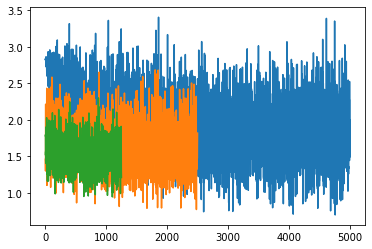

In [15]:
import matplotlib.pyplot as plt
model = TextClassifier(x_size, 0, y_size).to(device)
# params['batch_size'] = 1
# losses = train(model, train_dataset, 1, 0.1, 2)
# plt.plot(losses);
# params['batch_size'] = 2
# losses = train(model, train_dataset, 1, 0.1, 2)
# plt.plot(losses);
params['batch_size'] = 4
losses = train(model, train_dataset, 1, 0.1, 1)
plt.plot(losses);
params['batch_size'] = 8
losses = train(model, train_dataset, 1, 0.1, 1)
plt.plot(losses);
params['batch_size'] = 16
losses = train(model, train_dataset, 1, 0.2, 1)
plt.plot(losses);
plt.show();

Epoch:  0 Accuracy: 0.612 Loss:1.406


Epoch:  1 Accuracy: 0.626 Loss:1.270


Epoch:  2 Accuracy: 0.648 Loss:1.173


Epoch:  3 Accuracy: 0.662 Loss:1.099


Epoch:  4 Accuracy: 0.674 Loss:1.039


Epoch:  5 Accuracy: 0.679 Loss:0.990


Epoch:  6 Accuracy: 0.691 Loss:0.948


Epoch:  7 Accuracy: 0.694 Loss:0.913


Epoch:  8 Accuracy: 0.695 Loss:0.881


Epoch:  9 Accuracy: 0.703 Loss:0.854


Epoch: 10 Accuracy: 0.709 Loss:0.829


Epoch: 11 Accuracy: 0.711 Loss:0.808


Epoch: 12 Accuracy: 0.713 Loss:0.788


Epoch: 13 Accuracy: 0.714 Loss:0.770


Epoch: 14 Accuracy: 0.713 Loss:0.754


Epoch: 15 Accuracy: 0.712 Loss:0.739


Epoch: 16 Accuracy: 0.720 Loss:0.725


Epoch: 17 Accuracy: 0.718 Loss:0.713


Epoch: 18 Accuracy: 0.718 Loss:0.702


Epoch: 19 Accuracy: 0.720 Loss:0.691


Epoch: 20 Accuracy: 0.719 Loss:0.682


Epoch: 21 Accuracy: 0.721 Loss:0.673


Epoch: 22 Accuracy: 0.718 Loss:0.665


Epoch: 23 Accuracy: 0.726 Loss:0.657


Epoch: 24 Accuracy: 0.724 Loss:0.650


Epoch: 25 Accuracy: 0.722 Loss:0.644


Epoch: 26 Accuracy: 0.719 Loss:0.638


Epoch: 27 Accuracy: 0.722 Loss:0.633


Epoch: 28 Accuracy: 0.721 Loss:0.628


Epoch: 29 Accuracy: 0.724 Loss:0.624


Epoch: 30 Accuracy: 0.724 Loss:0.620


Epoch: 31 Accuracy: 0.723 Loss:0.616


Epoch: 32 Accuracy: 0.723 Loss:0.613


Epoch: 33 Accuracy: 0.724 Loss:0.610


Epoch: 34 Accuracy: 0.724 Loss:0.608


Epoch: 35 Accuracy: 0.724 Loss:0.606


Epoch: 36 Accuracy: 0.723 Loss:0.604


Epoch: 37 Accuracy: 0.723 Loss:0.603


Epoch: 38 Accuracy: 0.724 Loss:0.602


Epoch: 39 Accuracy: 0.724 Loss:0.601



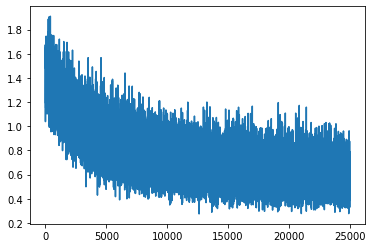

In [16]:
params['batch_size'] = 32
losses = train(model, train_dataset, 40, 0.4, 1)
plt.plot(losses);